In [1]:
import torch 
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm
import random
from torch.utils.data import Subset

from Data.lorentz_dataset import * 
from src.LSTM.sym_lstm import *

import warnings
warnings.filterwarnings('ignore')

/mnt/d_disk/ch20b065/.conda/envs/liegan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# data_dict = generate_lorenz_dataset(
#     save_path='./data/lorenz_dataset.pkl',
#     num_trajectories=2000,
#     t_span=(0, 10),  # Longer time span to capture chaotic behavior
#     num_steps=100,
#     test_split=0.2
# )

In [3]:
print('Loading lorentz dataset...') 
with open('Data/lorenz_dataset.pkl','rb') as file:
    data_dict = pickle.load(file) 

Loading lorentz dataset...


In [4]:
coords = data_dict['coords']
test_coords = data_dict['test_coords']

In [5]:
input_seq_length = 10
forecast_length = 2

train_dataset = TrajectoryDataset(coords,input_seq_length, forecast_length) 
test_dataset = TrajectoryDataset(test_coords,input_seq_length,forecast_length)

# Get the actual size of the dataset
train_size = 2000
test_size = 400

# Sample accordingly
train_indices = np.random.choice(len(train_dataset), size=train_size, replace=False)
test_indices = np.random.choice(len(test_dataset), size=test_size, replace=False)

train_dataset = Subset(train_dataset,train_indices)
test_dataset = Subset(test_dataset,test_indices)


In [6]:
batch_size = 64
epochs = 100
lr = 1e-3

n_dim = coords.shape[-1]


model,stats_norm = train_LSTMModel(
    train_dataset, test_dataset, batch_size, epochs, lr, n_dim, forecast_length
)

Starting training: 100 epochs


  2%|▏         | 2/100 [00:00<00:22,  4.30it/s]

Epoch 1/100, Train Loss: 223.947286, Test Loss: 166.682332


 12%|█▏        | 12/100 [00:01<00:09,  9.06it/s]

Epoch 11/100, Train Loss: 67.775158, Test Loss: 66.733097


 22%|██▏       | 22/100 [00:02<00:08,  9.38it/s]

Epoch 21/100, Train Loss: 8.384851, Test Loss: 3.928653


 32%|███▏      | 32/100 [00:03<00:07,  9.15it/s]

Epoch 31/100, Train Loss: 5.589519, Test Loss: 1.299007


 42%|████▏     | 42/100 [00:04<00:06,  9.02it/s]

Epoch 41/100, Train Loss: 4.500599, Test Loss: 0.770667


 52%|█████▏    | 52/100 [00:05<00:05,  9.30it/s]

Epoch 51/100, Train Loss: 4.202821, Test Loss: 0.504501


 62%|██████▏   | 62/100 [00:06<00:03,  9.56it/s]

Epoch 61/100, Train Loss: 4.120601, Test Loss: 0.433446


 72%|███████▏  | 72/100 [00:08<00:03,  9.27it/s]

Epoch 71/100, Train Loss: 3.951647, Test Loss: 0.458926


 82%|████████▏ | 82/100 [00:09<00:01,  9.40it/s]

Epoch 81/100, Train Loss: 4.046869, Test Loss: 0.600385


 92%|█████████▏| 92/100 [00:10<00:00,  9.08it/s]

Epoch 91/100, Train Loss: 3.899049, Test Loss: 0.449769


100%|██████████| 100/100 [00:11<00:00,  8.99it/s]

Epoch 100/100, Train Loss: 4.081554, Test Loss: 0.545253


In [7]:
def forecast_future(model,last_sequence,n_steps,feature_dim,device=None):
    if device is None:
        device = get_device()
        
    model = model.to(device)
    model.eval() 

    # Convert to tensor and add batch dimension
    sequence = torch.FloatTensor(last_sequence).unsqueeze(0).to(device)
    forecast_horizon = model(sequence).size(1) 

    forecast = np.zeros((n_steps,feature_dim)) 

    current_sequence = sequence.clone() 

    for i in range(0,n_steps,forecast_horizon):
        with torch.no_grad():
            next_steps = model(current_sequence) 

            if next_steps.ndim == 2:
                next_steps = next_steps.view(-1, forecast_horizon, feature_dim)


            next_steps = next_steps.cpu().numpy()[0] 

        # add to forecast 
        steps_to_add = min(forecast_horizon,n_steps-i) 
        forecast[i:i+steps_to_add] = next_steps[:steps_to_add]

        if i+forecast_horizon < n_steps:
            new_sequence = torch.cat([
                current_sequence[:,forecast_horizon:,:],
                torch.FloatTensor(next_steps).unsqueeze(0).to(device)
            ],dim=1) 
            current_sequence = new_sequence

        
    return forecast

In [8]:
last_sequence = test_coords[0,:10,:]
n_steps = len(test_coords[0,:,:])-len(last_sequence)

forecast = forecast_future(model,last_sequence,n_steps,n_dim)

In [9]:
full_forecast = np.concatenate([last_sequence,forecast],axis=0)

In [10]:
# Initializing the symmetry groups 
batch_size = 64
epochs = 50
lr = 1e-3

n_dim = coords.shape[-1]
n_channel = 1

lie_algebra = get_generators(n_dim,n_channel,'saved_model/LieGAN/lorentz/lorentz_generator_99.pt','lorentz')
G = CustomGroup(n_dim,lie_algebra) 

In [11]:
from train import * 
from src.autoencoder import * 
from src.gan import LieDiscriminator, LieGenerator 

w_recon = 1
w_gan = 1
w_reg = 1e-2 
w_chreg = 0 
w_reg_z = 1e-3
w_reg_x = 1
log_interval = 1
save_interval = 100 

reg_type = 'cosine'

num_epochs = 100
batch_size = 64
lr_ae = 1e-3 
lr_g = 1e-3
lr_d = 1e-3 
lr_reg = 1e-3

hidden_dim=128
latent_dim = 2
n_layers_ae = 3

device= get_device()
save_dir = 'LaLiGAN/vanilla/lorentz'

train_loader = DataLoader(train_dataset,batch_size=batch_size)
test_loader = DataLoader(test_dataset,batch_size=batch_size)



In [12]:
autoencoder = AutoEncoder(n_dim,hidden_dim,latent_dim,n_layers_ae).to(device)

In [13]:
class Args:
    def __init__(self):
        # model & training settings
        self.batch_size = 64
        self.num_epochs = 100
        self.lr_d = 2e-4
        self.lr_g = 1e-3
        self.reg_type = 'cosine'
        self.lamda = 1e-2
        self.p_norm = 2
        self.droprate_init = 0.8
        self.mu = 0.0
        self.activate_threshold = False
        self.D_loss_threshold = 0.25
        self.model = 'lie'
        self.coef_dist = 'normal'
        self.g_init = 'random'
        self.sigma_init = 1
        self.uniform_max = 1
        self.normalize_Li = False
        self.augment = False
        self.n_channel = 1
        self.eta = 1.0
        self.incremental = False
        
        # dataset settings
        self.task = 'lorentz'
        self.dataset_name = 'lorentz'
        self.dataset_config = None
        self.dataset_size = 2000
        self.x_type = 'vector'
        self.y_type = 'vector'
        self.input_timesteps = 1
        self.output_timesteps = 1
        self.n_component = 1
        self.noise = 0.0
        
        # run settings
        self.seed = 42
        self.gpu = 0
        self.print_every = 1
        self.save_path = 'saved_model'
        self.save_name = 'default'
        self.device = get_device()

        # regressor

# Create the args object with default values
args = Args()


In [14]:
# Defining the generator, discriminator and regressor

n_channel = args.n_channel
generator = LieGenerator(latent_dim,n_channel,args).to(args.device)

d_input_size = latent_dim*(input_seq_length + forecast_length)
discriminator = LieDiscriminator(d_input_size).to(args.device)

regressor = LSTMForecaster(
    latent_dim,
    hidden_dim,
    fc_dim=64,
    num_layers=2,
    output_dim=forecast_length,
    dropout=0.2,
).to(device)


In [15]:
stats = train_lassi(
    autoencoder, discriminator, generator, train_loader, test_loader,
    num_epochs, lr_ae, lr_d, lr_g, w_recon, w_gan, reg_type, w_reg, w_chreg,
    regressor, lr_reg,  w_reg_z, w_reg_x,
    device,save_interval, save_dir
)

Starting training: 100 epochs


  1%|          | 1/100 [00:00<01:23,  1.18it/s]

Epoch 1/100, Train Loss: 194.170999, Test Loss: 73.636899
loss_ae: 343.6879, loss_g: 0.3123, loss_g_reg: 0.9752, loss_g_chreg: 0.0000, loss_d_real: 0.3145, loss_d_fake: 1.3745, loss_ae_rel: 0.6553
Parameter containing:
tensor([[[-0.0729, -0.4903],
         [ 0.1950,  0.3987]]], device='cuda:3', requires_grad=True)


 11%|█         | 11/100 [00:06<00:53,  1.66it/s]

Epoch 11/100, Train Loss: 13.305348, Test Loss: 7.204420
loss_ae: 5.3706, loss_g: 0.2900, loss_g_reg: 0.9961, loss_g_chreg: 0.0000, loss_d_real: 0.2883, loss_d_fake: 1.3842, loss_ae_rel: 0.0102
Parameter containing:
tensor([[[ 0.0581, -0.1516],
         [-0.0006,  0.2695]]], device='cuda:3', requires_grad=True)


 21%|██        | 21/100 [00:12<00:52,  1.50it/s]

Epoch 21/100, Train Loss: 5.236026, Test Loss: 2.274994
loss_ae: 3.6683, loss_g: 0.2919, loss_g_reg: 0.9993, loss_g_chreg: 0.0000, loss_d_real: 0.2904, loss_d_fake: 1.3861, loss_ae_rel: 0.0070
Parameter containing:
tensor([[[ 0.1266, -0.0695],
         [ 0.0053,  0.2215]]], device='cuda:3', requires_grad=True)


 31%|███       | 31/100 [00:19<00:44,  1.57it/s]

Epoch 31/100, Train Loss: 3.861984, Test Loss: 1.341322
loss_ae: 3.1238, loss_g: 0.2900, loss_g_reg: 0.9984, loss_g_chreg: 0.0000, loss_d_real: 0.2886, loss_d_fake: 1.3857, loss_ae_rel: 0.0059
Parameter containing:
tensor([[[0.1693, 0.0422],
         [0.1295, 0.1873]]], device='cuda:3', requires_grad=True)


 41%|████      | 41/100 [00:25<00:38,  1.55it/s]

Epoch 41/100, Train Loss: 3.265909, Test Loss: 1.191260
loss_ae: 2.8457, loss_g: 0.2898, loss_g_reg: 0.9995, loss_g_chreg: 0.0000, loss_d_real: 0.2889, loss_d_fake: 1.3861, loss_ae_rel: 0.0054
Parameter containing:
tensor([[[0.1143, 0.0540],
         [0.0449, 0.1679]]], device='cuda:3', requires_grad=True)


 51%|█████     | 51/100 [00:31<00:29,  1.68it/s]

Epoch 51/100, Train Loss: 2.718750, Test Loss: 0.893099
loss_ae: 2.6139, loss_g: 0.2894, loss_g_reg: 0.9999, loss_g_chreg: 0.0000, loss_d_real: 0.2903, loss_d_fake: 1.3862, loss_ae_rel: 0.0050
Parameter containing:
tensor([[[0.1481, 0.0359],
         [0.0109, 0.1312]]], device='cuda:3', requires_grad=True)


 61%|██████    | 61/100 [00:37<00:22,  1.76it/s]

Epoch 61/100, Train Loss: 2.413931, Test Loss: 0.802498
loss_ae: 2.5732, loss_g: 0.2897, loss_g_reg: 0.9998, loss_g_chreg: 0.0000, loss_d_real: 0.2892, loss_d_fake: 1.3861, loss_ae_rel: 0.0049
Parameter containing:
tensor([[[ 0.1139,  0.0244],
         [-0.0332,  0.1017]]], device='cuda:3', requires_grad=True)


 71%|███████   | 71/100 [00:43<00:15,  1.83it/s]

Epoch 71/100, Train Loss: 2.083993, Test Loss: 0.801587
loss_ae: 2.3926, loss_g: 0.2896, loss_g_reg: 0.9999, loss_g_chreg: 0.0000, loss_d_real: 0.2902, loss_d_fake: 1.3861, loss_ae_rel: 0.0045
Parameter containing:
tensor([[[ 0.1076,  0.0294],
         [-0.0137,  0.0637]]], device='cuda:3', requires_grad=True)


 81%|████████  | 81/100 [00:48<00:13,  1.45it/s]

Epoch 81/100, Train Loss: 1.967191, Test Loss: 0.723429
loss_ae: 2.3074, loss_g: 0.2891, loss_g_reg: 0.9999, loss_g_chreg: 0.0000, loss_d_real: 0.2900, loss_d_fake: 1.3819, loss_ae_rel: 0.0044
Parameter containing:
tensor([[[0.0853, 0.0245],
         [0.0035, 0.0615]]], device='cuda:3', requires_grad=True)


 91%|█████████ | 91/100 [00:54<00:05,  1.62it/s]

Epoch 91/100, Train Loss: 1.852128, Test Loss: 0.858358
loss_ae: 2.1778, loss_g: 0.2887, loss_g_reg: 1.0000, loss_g_chreg: 0.0000, loss_d_real: 0.2892, loss_d_fake: 1.3862, loss_ae_rel: 0.0041
Parameter containing:
tensor([[[0.0665, 0.0187],
         [0.0032, 0.0692]]], device='cuda:3', requires_grad=True)


100%|██████████| 100/100 [01:00<00:00,  1.66it/s]

Epoch 100/100, Train Loss: 1.724462, Test Loss: 0.922455
loss_ae: 2.1094, loss_g: 0.2884, loss_g_reg: 1.0000, loss_g_chreg: 0.0000, loss_d_real: 0.2891, loss_d_fake: 1.3868, loss_ae_rel: 0.0040
Parameter containing:
tensor([[[ 0.0612,  0.0112],
         [-0.0029,  0.0389]]], device='cuda:3', requires_grad=True)


In [16]:
def forecast_future_laligan(model, autoencoder, last_sequence, n_steps, feature_dim, device=None):
    if device is None:
        device = get_device()
    
    # Move models to device and set to evaluation mode
    model = model.to(device)
    autoencoder = autoencoder.to(device)
    model.eval()
    autoencoder.eval()
    
    # Verify input dimensions
    if len(last_sequence.shape) != 2 or last_sequence.shape[1] != feature_dim:
        raise ValueError(f"Expected last_sequence shape (seq_len, {feature_dim}), got {last_sequence.shape}")
    
    # Convert to tensor and add batch dimension
    with torch.no_grad():
        sequence = torch.FloatTensor(last_sequence).unsqueeze(0).to(device)
        
        # Encode the sequence
        sequence_enc, _ = autoencoder(sequence)
        
        # Get a sample prediction to determine forecast horizon
        sample_pred = model(sequence_enc)
        
        # Determine forecast horizon based on model output
        if len(sample_pred.shape) == 3:
            forecast_horizon = sample_pred.shape[1]
        else:
            forecast_horizon = 1
            sample_pred = sample_pred.unsqueeze(1)
        
        # Initialize forecast array
        forecast = np.zeros((n_steps, feature_dim))
        
        # Current sequence in latent space
        current_sequence_enc = sequence_enc.clone()
        
        # Generate predictions iteratively
        for i in range(0, n_steps, forecast_horizon):
            # Get next steps in latent space
            next_steps_enc = model(current_sequence_enc)
            
            # Ensure correct shape
            if len(next_steps_enc.shape) == 2:
                next_steps_enc = next_steps_enc.unsqueeze(1)
            
            # Decode to get actual predictions
            next_steps = autoencoder.decode(next_steps_enc)
            
            next_steps_np = next_steps.cpu().numpy()[0]
            
            steps_to_add = min(forecast_horizon, n_steps - i)
            forecast[i:i+steps_to_add] = next_steps_np[:steps_to_add]
            
            if i + forecast_horizon < n_steps:
                if next_steps_enc.shape[1] == forecast_horizon:
                    current_sequence_enc = torch.cat([
                        current_sequence_enc[:, forecast_horizon:, :],
                        next_steps_enc
                    ], dim=1)
    
    return forecast

In [17]:
last_sequence = test_coords[0,:10,:]
n_steps = len(test_coords[0,:,:])-len(last_sequence)

sym_forecast = forecast_future_laligan(regressor, autoencoder,last_sequence,n_steps,n_dim)

In [18]:
from src.LSTM.aug_lstm import *

generator_aug = get_generator(3,'saved_model/LieGAN/lorentz/args_lorentz.pkl')

model_aug, stats_aug = train_AugLSTMModel(
    generator_aug, train_dataset, test_dataset, batch_size, num_epochs, lr, n_dim, forecast_length
)

Starting training: 100 epochs


  1%|          | 1/100 [00:00<00:27,  3.59it/s]

Epoch 1/100, Train Loss: 220.547876, Test Loss: 151.204969


 11%|█         | 11/100 [00:03<00:24,  3.64it/s]

Epoch 11/100, Train Loss: 20.497384, Test Loss: 13.769824


 21%|██        | 21/100 [00:05<00:21,  3.69it/s]

Epoch 21/100, Train Loss: 6.827347, Test Loss: 2.516985


 31%|███       | 31/100 [00:08<00:18,  3.73it/s]

Epoch 31/100, Train Loss: 4.837382, Test Loss: 1.028370


 41%|████      | 41/100 [00:11<00:15,  3.73it/s]

Epoch 41/100, Train Loss: 4.132652, Test Loss: 0.753360


 51%|█████     | 51/100 [00:13<00:13,  3.73it/s]

Epoch 51/100, Train Loss: 3.835812, Test Loss: 0.640523


 61%|██████    | 61/100 [00:16<00:10,  3.74it/s]

Epoch 61/100, Train Loss: 3.602522, Test Loss: 0.700855


 71%|███████   | 71/100 [00:19<00:07,  3.80it/s]

Epoch 71/100, Train Loss: 3.467663, Test Loss: 0.503185


 81%|████████  | 81/100 [00:21<00:04,  4.06it/s]

Epoch 81/100, Train Loss: 3.196513, Test Loss: 0.362688


 91%|█████████ | 91/100 [00:24<00:02,  3.59it/s]

Epoch 91/100, Train Loss: 3.353003, Test Loss: 0.308729


100%|██████████| 100/100 [00:26<00:00,  3.73it/s]

Epoch 100/100, Train Loss: 3.235797, Test Loss: 0.436833


In [19]:
last_sequence = test_coords[0,:10,:]
n_steps = len(test_coords[0,:,:])-len(last_sequence)

forecast_aug = forecast_future(model_aug,last_sequence,n_steps,n_dim)

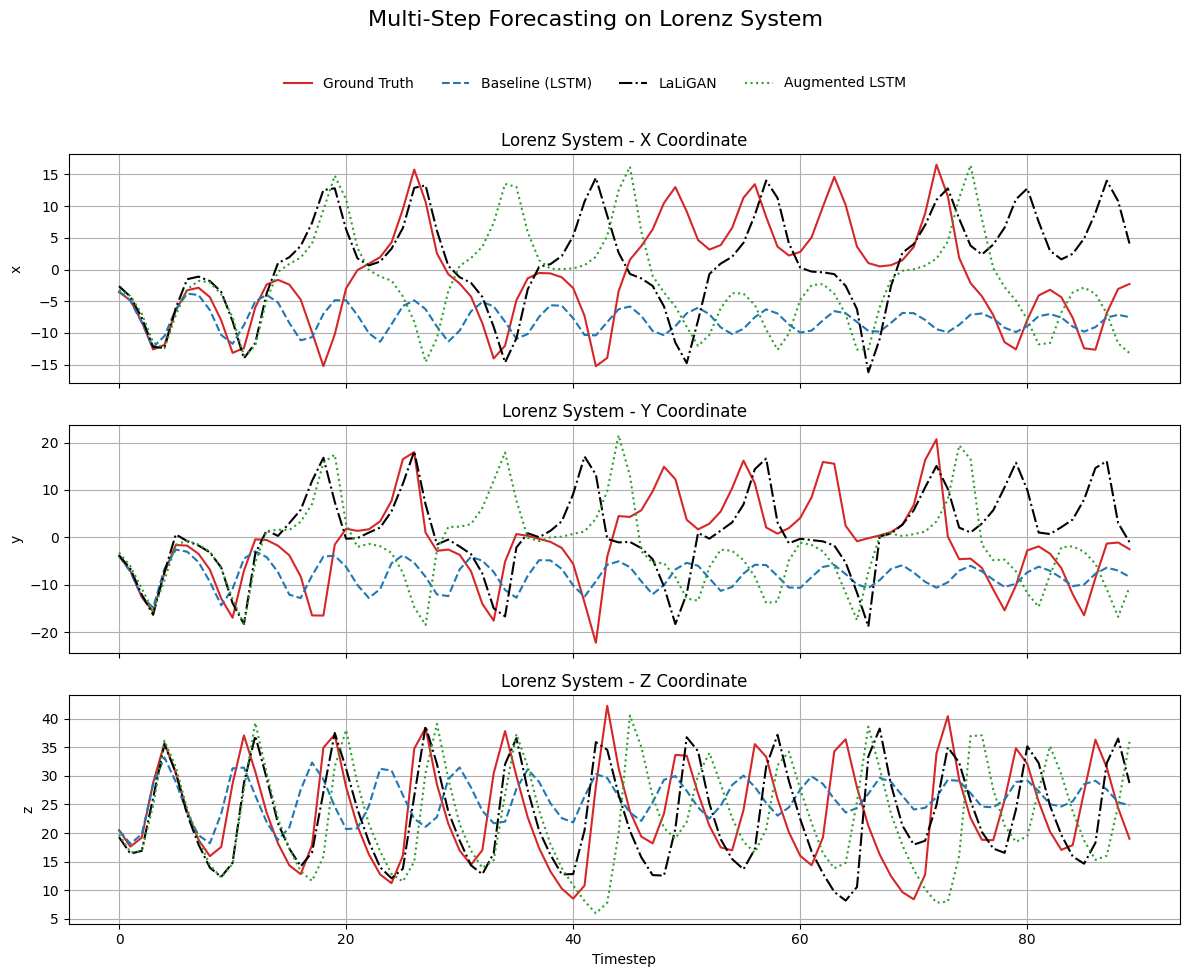

In [20]:
# Colors for each model
colors = {
    'ground_truth': '#d62728',   # red
    'baseline': '#1f77b4',       # blue
    'laligan': '#000000',        # black
    'augmented': '#2ca02c',      # green
}

# Line styles
line_styles = {
    'ground_truth': '-',
    'baseline': '--',
    'laligan': '-.',
    'augmented': ':',
}

# Extract coordinates
x, y, z = test_coords[0, 10:, 0], test_coords[0, 10:, 1], test_coords[0, 10:, 2]
x_pred_sym, y_pred_sym, z_pred_sym = sym_forecast[:, 0], sym_forecast[:, 1], sym_forecast[:, 2]
x_pred, y_pred, z_pred = forecast[:, 0], forecast[:, 1], forecast[:, 2]
x_pred_aug, y_pred_aug, z_pred_aug = forecast_aug[:, 0], forecast_aug[:, 1], forecast_aug[:, 2]

# Create figure
fig, axs = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

# --- Plot x ---
axs[0].plot(x, label='Ground Truth', color=colors['ground_truth'], linestyle=line_styles['ground_truth'])
axs[0].plot(x_pred, label='Baseline (LSTM)', color=colors['baseline'], linestyle=line_styles['baseline'])
axs[0].plot(x_pred_sym, label='LaLiGAN', color=colors['laligan'], linestyle=line_styles['laligan'])
axs[0].plot(x_pred_aug, label='Augmented LSTM', color=colors['augmented'], linestyle=line_styles['augmented'])
axs[0].set_title('Lorenz System - X Coordinate')
axs[0].set_ylabel('x')
axs[0].grid(True)

# --- Plot y ---
axs[1].plot(y, label='Ground Truth', color=colors['ground_truth'], linestyle=line_styles['ground_truth'])
axs[1].plot(y_pred, label='Baseline (LSTM)', color=colors['baseline'], linestyle=line_styles['baseline'])
axs[1].plot(y_pred_sym, label='LaLiGAN', color=colors['laligan'], linestyle=line_styles['laligan'])
axs[1].plot(y_pred_aug, label='Augmented LSTM', color=colors['augmented'], linestyle=line_styles['augmented'])
axs[1].set_title('Lorenz System - Y Coordinate')
axs[1].set_ylabel('y')
axs[1].grid(True)

# --- Plot z ---
axs[2].plot(z, label='Ground Truth', color=colors['ground_truth'], linestyle=line_styles['ground_truth'])
axs[2].plot(z_pred, label='Baseline (LSTM)', color=colors['baseline'], linestyle=line_styles['baseline'])
axs[2].plot(z_pred_sym, label='LaLiGAN', color=colors['laligan'], linestyle=line_styles['laligan'])
axs[2].plot(z_pred_aug, label='Augmented LSTM', color=colors['augmented'], linestyle=line_styles['augmented'])
axs[2].set_title('Lorenz System - Z Coordinate')
axs[2].set_ylabel('z')
axs[2].set_xlabel('Timestep')
axs[2].grid(True)

# Add a shared legend above all plots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.02), frameon=False)

plt.suptitle('Multi-Step Forecasting on Lorenz System', fontsize=16, y=1.08)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

In [21]:
## Computing Error metrics 

n = 10  # Number of samples
indices = np.random.choice(test_coords.shape[0], min(n,test_coords.shape[0]), replace=False)

def mse_comp(arr1,arr2):
    assert arr1.shape == arr2.shape 

    squared_diff = (arr1-arr2)**2 
    return np.mean(squared_diff)

mse = {
    'LSTM':[],
    'LSTM aug':[],
    'LSTM laligan':[], 
}

for i,idx in enumerate(indices):
    print(f'Trial {i+1}')
    sim = test_coords[idx,10:,:]

    last_sequence = test_coords[idx,:10,:]
    n_steps = len(test_coords[idx,:,:])-len(last_sequence)

    sym_forecast = forecast_future_laligan(regressor, autoencoder,last_sequence,n_steps,n_dim)
    aug_forecast = forecast_future(model_aug,last_sequence,n_steps,n_dim)
    forecast = forecast_future(model,last_sequence,n_steps,n_dim)


    mse['LSTM'].append(mse_comp(sim,forecast))
    mse['LSTM aug'].append(mse_comp(sim,aug_forecast))
    mse['LSTM laligan'].append(mse_comp(sim,sym_forecast))


Trial 1


Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10


In [22]:
for k in mse.keys():
    print(f'{k} : {np.mean(mse[k])}')

LSTM : 102.30708574217677
LSTM aug : 118.74073358121589
LSTM laligan : 102.26436787393929


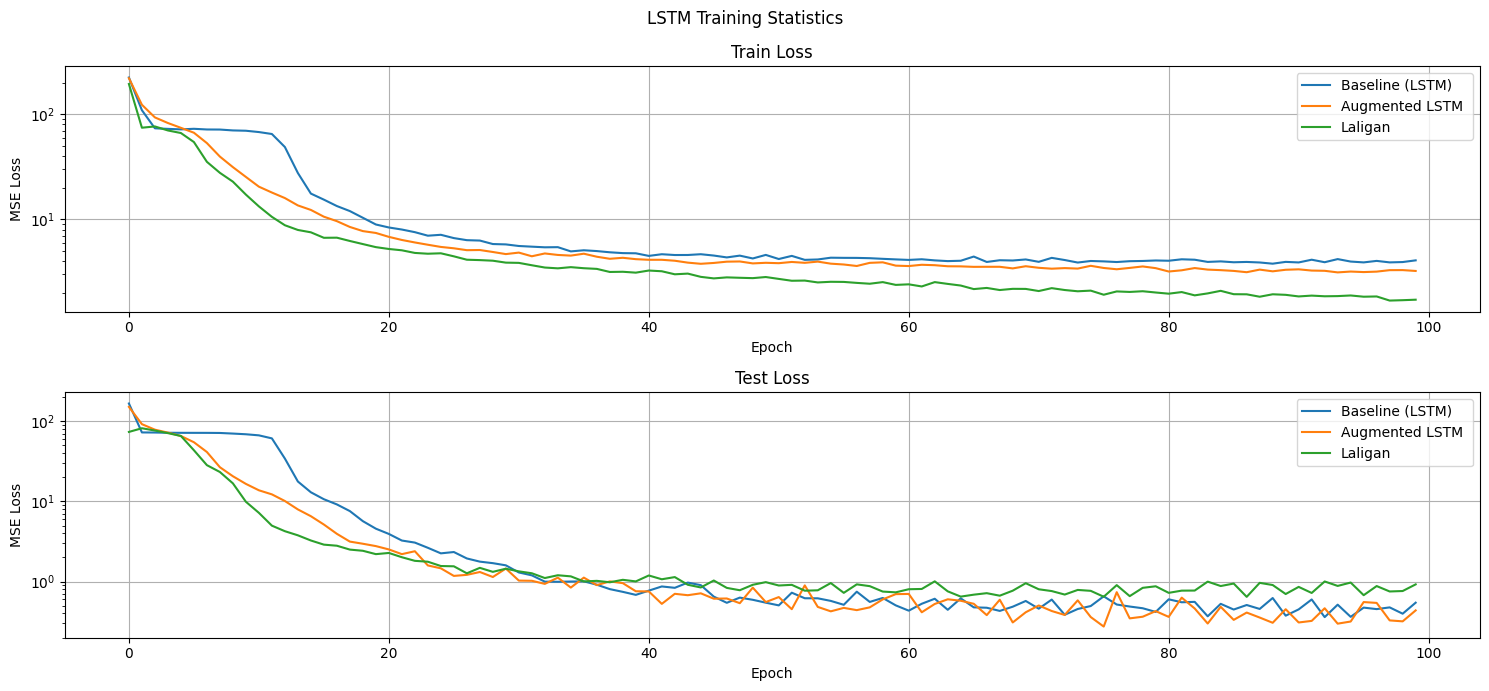

: 

In [28]:
# Plot training statistics
plt.figure(figsize=(15, 7))

plt.subplot(2, 1, 1)
plt.plot(stats_norm['train_loss'],label='Baseline (LSTM)')
plt.plot(stats_aug['train_loss'],label='Augmented LSTM ')
plt.plot(stats['train_loss'],label='Laligan')
plt.yscale('log')
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(stats_norm['test_loss'],label='Baseline (LSTM)')
plt.plot(stats_aug['test_loss'],label='Augmented LSTM ')
plt.plot(stats['test_loss'],label='Laligan')
plt.yscale('log')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.suptitle('LSTM Training Statistics')
plt.tight_layout()
plt.show()

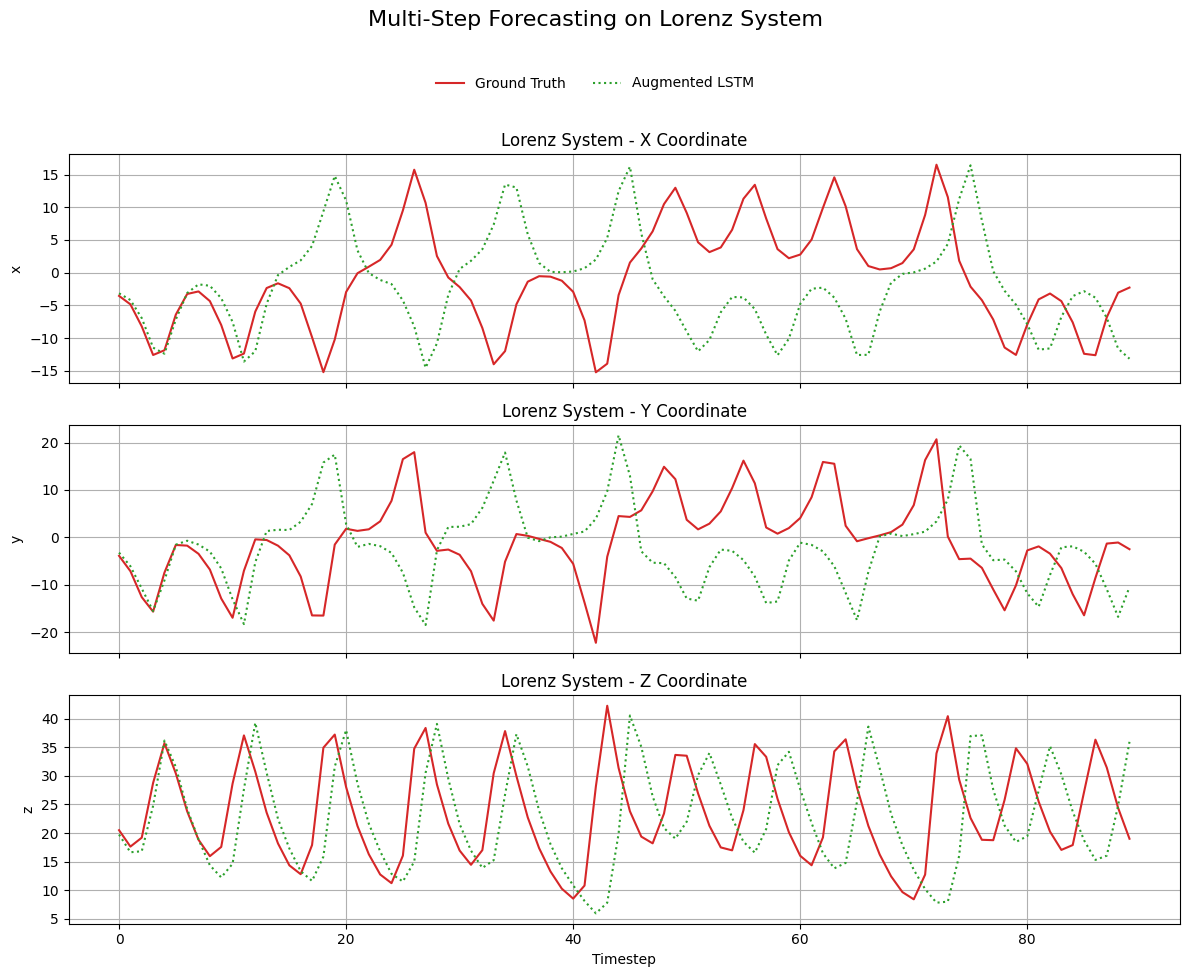

In [27]:
# Colors for each model
colors = {
    'ground_truth': '#d62728',   # red
    'baseline': '#1f77b4',       # blue
    'laligan': '#000000',        # black
    'augmented': '#2ca02c',      # green
}

# Line styles
line_styles = {
    'ground_truth': '-',
    'baseline': '--',
    'laligan': '-.',
    'augmented': ':',
}

# Extract coordinates
x, y, z = test_coords[0, 10:, 0], test_coords[0, 10:, 1], test_coords[0, 10:, 2]
x_pred_sym, y_pred_sym, z_pred_sym = sym_forecast[:, 0], sym_forecast[:, 1], sym_forecast[:, 2]
x_pred, y_pred, z_pred = forecast[:, 0], forecast[:, 1], forecast[:, 2]
x_pred_aug, y_pred_aug, z_pred_aug = forecast_aug[:, 0], forecast_aug[:, 1], forecast_aug[:, 2]

# Create figure
fig, axs = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

# --- Plot x ---
axs[0].plot(x, label='Ground Truth', color=colors['ground_truth'], linestyle=line_styles['ground_truth'])
# axs[0].plot(x_pred, label='Baseline (LSTM)', color=colors['baseline'], linestyle=line_styles['baseline'])
# axs[0].plot(x_pred_sym, label='LaLiGAN', color=colors['laligan'], linestyle=line_styles['laligan'])
axs[0].plot(x_pred_aug, label='Augmented LSTM', color=colors['augmented'], linestyle=line_styles['augmented'])
axs[0].set_title('Lorenz System - X Coordinate')
axs[0].set_ylabel('x')
axs[0].grid(True)

# --- Plot y ---
axs[1].plot(y, label='Ground Truth', color=colors['ground_truth'], linestyle=line_styles['ground_truth'])
# axs[1].plot(y_pred, label='Baseline (LSTM)', color=colors['baseline'], linestyle=line_styles['baseline'])
# axs[1].plot(y_pred_sym, label='LaLiGAN', color=colors['laligan'], linestyle=line_styles['laligan'])
axs[1].plot(y_pred_aug, label='Augmented LSTM', color=colors['augmented'], linestyle=line_styles['augmented'])
axs[1].set_title('Lorenz System - Y Coordinate')
axs[1].set_ylabel('y')
axs[1].grid(True)

# --- Plot z ---
axs[2].plot(z, label='Ground Truth', color=colors['ground_truth'], linestyle=line_styles['ground_truth'])
# axs[2].plot(z_pred, label='Baseline (LSTM)', color=colors['baseline'], linestyle=line_styles['baseline'])
# axs[2].plot(z_pred_sym, label='LaLiGAN', color=colors['laligan'], linestyle=line_styles['laligan'])
axs[2].plot(z_pred_aug, label='Augmented LSTM', color=colors['augmented'], linestyle=line_styles['augmented'])
axs[2].set_title('Lorenz System - Z Coordinate')
axs[2].set_ylabel('z')
axs[2].set_xlabel('Timestep')
axs[2].grid(True)

# Add a shared legend above all plots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.02), frameon=False)

plt.suptitle('Multi-Step Forecasting on Lorenz System', fontsize=16, y=1.08)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()